In [2]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(readr)
    library(reticulate)
    library(gridExtra)
    library(grid)
    library(ggpubr)
    library(scales)
    library(patchwork)
    library(stringr)
    library("vcd")
    library(future)
}))
#use_condaenv("R42")
#source_python("/home/vsevim/prj/workflows/catatac/secondary/mixture.py")

In [3]:
# Definitions etc
set.seed(1234)
options(digits=2)
stats <- c()

options(future.globals.maxSize= 250 * 1024^3) # 650Gb
# plan()

# Enable parallelization
plan(sequential)
plan("multicore", workers = 64)

custom_theme <- theme(
plot.title = element_text(size=16, hjust = 0.5), 
legend.key.size = unit(0.7, "cm"), 
legend.text = element_text(size = 14))

# Load guide-capture data

Define paths etc

In [4]:
if(!exists("papermill_run")) {
    prj_name = "Screen1_66guides"
    secondary_a_path = "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/"
    save_seurat_h5 = "NO"

    h5_name = "/home/jupyter-ayang/notebooks/cat-atac_pipeline/K562/secondary/output/seurat/CATATAC_K562_CRISPR_ONLY_SINGLETS.h5seurat"
    protosp_path = "/home/jupyter-ayang/notebooks/cat-atac_pipeline/K562/primary/output/resources/ps_long_sep.tsv"
    library = "K562_CRISPR"
    tsv_path = "/home/jupyter-ayang/notebooks/cat-atac_pipeline/K562/primary/output/tsv"
}

In [5]:
h5_w_gcap_name <- sub(".h5seurat", "_w_GUIDE_CAP.h5seurat", h5_name)
barcode2guide_tsv_path <- paste0(tsv_path, "/", library, "_ALL_STRUCTURED.TSV")
tsv_name <- paste0(tsv_path, "/", library, "_guide_PIVOT.TSV")
min_guide_count = 10

In [6]:
tsv_name

[1] "/home/jupyter-ayang/notebooks/cat-atac_pipeline/K562/primary/output/tsv/K562_CRISPR_guide_PIVOT.TSV"

### Load protospacer file

In [7]:
df_protosp = read.table(protosp_path, header=TRUE, comment.char="")

In [8]:
tfs_w_ntctl    = unique(df_protosp$X.TargetGene)
unselect_ntctl = (tfs_w_ntctl != "NTCTL") & (tfs_w_ntctl != "NTCTRL")
tfs_to_plot    = tfs_w_ntctl[unselect_ntctl]

guides_to_plot  = df_protosp$GuideName
tfs_to_plot
guides_to_plot

NULL

[1] "ARID1A_1" "ARID1A_2" "ARID1A_3" "ARID1A_4" "ATRX_1"   "ATRX_2"  
 [7] "ATRX_3"   "ATRX_4"   "CHD8_1"   "CHD8_2"   "CHD8_3"   "CHD8_4"  
[13] "DNMT3A_1" "DNMT3A_2" "DNMT3A_3" "DNMT3A_4" "EZH2_1"   "EZH2_2"  
[19] "EZH2_3"   "EZH2_4"   "HDAC9_1"  "HDAC9_2"  "HDAC9_3"  "HDAC9_4" 
[25] "KDM6A_1"  "KDM6A_2"  "KDM6A_3"  "KDM6A_4"  "MBD1_1"   "MBD1_2"  
[31] "MBD1_3"   "MBD1_4"   "NTCTL_1"  "NTCTL_2"  "NTCTL_3"  "NTCTL_4" 
[37] "PBRM1_1"  "PBRM1_2"  "PBRM1_3"  "PBRM1_4"  "PRDM9_1"  "PRDM9_2" 
[43] "PRDM9_3"  "PRDM9_4"  "SETD2_1"  "SETD2_2"  "SETD2_3"  "SETD2_4" 
[49] "TET2_1"   "TET2_2"   "TET2_3"   "TET2_4"

In [9]:
#c("OTP", "MYF6", "MEIS1", "FLI1", "HHEX", "HOXA6", "ELF5", "GBX1", "DPRX", "NTCTL")
##!! tf_list   <- tfs_w_ntctl 

df_guide <- read.table(tsv_name, header = TRUE, sep = "\t", quote = "")
tf_list  <- intersect(guides_to_plot, colnames(df_guide))

guide_counts  <- t(data.matrix(df_guide[,tf_list]))
colnames(guide_counts) <- df_guide$barcode_dash

In [10]:
colnames(df_guide)
guides_to_plot

[1] "barcode"      "n_guides"     "na"           "ARID1A_1"     "ARID1A_2"    
 [6] "ARID1A_3"     "ARID1A_4"     "ATRX_1"       "ATRX_2"       "ATRX_3"      
[11] "ATRX_4"       "CHD8_1"       "CHD8_2"       "CHD8_3"       "CHD8_4"      
[16] "DNMT3A_1"     "DNMT3A_2"     "DNMT3A_3"     "DNMT3A_4"     "EZH2_1"      
[21] "EZH2_2"       "EZH2_3"       "EZH2_4"       "HDAC9_1"      "HDAC9_2"     
[26] "HDAC9_3"      "HDAC9_4"      "KDM6A_1"      "KDM6A_2"      "KDM6A_3"     
[31] "KDM6A_4"      "MBD1_1"       "MBD1_2"       "MBD1_3"       "MBD1_4"      
[36] "NTCTL_3"      "NTCTL_4"      "PBRM1_1"      "PBRM1_2"      "PBRM1_3"     
[41] "PBRM1_4"      "PRDM9_1"      "PRDM9_2"      "PRDM9_3"      "PRDM9_4"     
[46] "SETD2_1"      "SETD2_2"      "SETD2_3"      "SETD2_4"      "TET2_1"      
[51] "TET2_2"       "TET2_3"       "TET2_4"       "barcode_dash" "in_multiome"

[1] "ARID1A_1" "ARID1A_2" "ARID1A_3" "ARID1A_4" "ATRX_1"   "ATRX_2"  
 [7] "ATRX_3"   "ATRX_4"   "CHD8_1"   "CHD8_2"   "CHD8_3"   "CHD8_4"  
[13] "DNMT3A_1" "DNMT3A_2" "DNMT3A_3" "DNMT3A_4" "EZH2_1"   "EZH2_2"  
[19] "EZH2_3"   "EZH2_4"   "HDAC9_1"  "HDAC9_2"  "HDAC9_3"  "HDAC9_4" 
[25] "KDM6A_1"  "KDM6A_2"  "KDM6A_3"  "KDM6A_4"  "MBD1_1"   "MBD1_2"  
[31] "MBD1_3"   "MBD1_4"   "NTCTL_1"  "NTCTL_2"  "NTCTL_3"  "NTCTL_4" 
[37] "PBRM1_1"  "PBRM1_2"  "PBRM1_3"  "PBRM1_4"  "PRDM9_1"  "PRDM9_2" 
[43] "PRDM9_3"  "PRDM9_4"  "SETD2_1"  "SETD2_2"  "SETD2_3"  "SETD2_4" 
[49] "TET2_1"   "TET2_2"   "TET2_3"   "TET2_4"

In [11]:
sum(df_guide$in_multiome)
nrow(df_guide)

[1] 9022

[1] 105314

Get cells with guides

In [12]:
N_MIN_GUIDES <- 10
select_overlapping   <-
    df_guide$in_multiome & (df_guide$n_guide >= N_MIN_GUIDES)

overlapping_barcodes <- df_guide[select_overlapping, ]$barcode_dash
overlapping_barcodes <- as.vector(overlapping_barcodes)

overlapping_guide_counts <- guide_counts[, overlapping_barcodes]

n_all_overlapping <- nrow(df_guide[df_guide$in_multiome, ])
paste("Overlapping barcodes w/ min guides =", N_MIN_GUIDES,": ", length(overlapping_barcodes))
paste("Overlapping barcodes w/ min guides =", 1,": ", n_all_overlapping)

[1] "Overlapping barcodes w/ min guides = 10 :  8992"

[1] "Overlapping barcodes w/ min guides = 1 :  9022"

Load seurat

In [13]:
# Load multiome seurat object
if (!exists("seurat_all")) {
    seurat_all <- LoadH5Seurat(h5_name, verbose = F)
}

Validating h5Seurat file



Filter out cells w/o guides

In [14]:
seurat <- subset(seurat_all, cells = overlapping_barcodes)

Create sgRNA assay

In [15]:
# Reorder the guide cells and create an sgRNA assay
cells = Cells(seurat)
sgrna_assay <- CreateAssayObject(counts = guide_counts[, cells])
seurat[["sgRNA"]] <- sgrna_assay

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


In [16]:
head(guide_counts)

,AAACAGCCAACAGGAT-1,AAACAGCCAACCCTAA-1,AAACAGCCAACTAGCC-1,AAACAGCCAAGCCACT-1,AAACAGCCAAGCCAGA-1,AAACAGCCAAGTTATC-1,AAACAGCCAATAACCT-1,AAACAGCCAATCATGT-1,AAACAGCCAATCCTGA-1,AAACAGCCAATCTCTC-1,⋯,TTTGTTGGTTGCCTCA-1,TTTGTTGGTTGGTTAG-1,TTTGTTGGTTGTCCAT-1,TTTGTTGGTTGTGACA-1,TTTGTTGGTTGTTCAC-1,TTTGTTGGTTTAACGG-1,TTTGTTGGTTTACCGT-1,TTTGTTGGTTTAGCTC-1,TTTGTTGGTTTGGTTC-1,TTTGTTGGTTTGTCTA-1
ARID1A_1,0,0,0,0,0,2,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ARID1A_2,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ARID1A_3,0,0,0,0,0,8,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ARID1A_4,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ATRX_1,0,0,0,0,0,8,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ATRX_2,0,0,0,218,0,10,0,0,0,0,⋯,0,0,0,0,1,2,0,0,0,0


# Plot guide distr

Skipping guides with less than 10 counts in assay
ARID1A-1 669 guides found
ARID1A-2 1035 guides found
ARID1A-3 1359 guides found
ARID1A-4 6 guides found
Skipping ARID1A-4 6 guides found
ATRX-1 1359 guides found
ATRX-2 2827 guides found
ATRX-3 6040 guides found
ATRX-4 1213 guides found
CHD8-1 463 guides found
CHD8-2 1402 guides found
CHD8-3 2447 guides found
CHD8-4 2591 guides found
DNMT3A-1 831 guides found
DNMT3A-2 785 guides found
DNMT3A-3 19 guides found
DNMT3A-4 13 guides found
EZH2-1 2327 guides found
EZH2-2 2418 guides found
EZH2-3 4173 guides found
EZH2-4 3823 guides found
HDAC9-1 121 guides found
HDAC9-2 501 guides found
HDAC9-3 556 guides found
HDAC9-4 1106 guides found
KDM6A-1 3329 guides found
KDM6A-2 1128 guides found
KDM6A-3 237 guides found
KDM6A-4 1238 guides found
MBD1-1 2784 guides found
MBD1-2 3578 guides found
MBD1-3 453 guides found
MBD1-4 1953 guides found
NTCTL-3 5473 guides found
NTCTL-4 3551 guides found
PBRM1-1 1275 guides found
PBRM1-2 1584 guides found
PBRM1

Warning message:
"Removed 82 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 2 rows containing missing values (`geom_bar()`)."
Warning message:
"Removed 110 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 2 rows containing missing values (`geom_bar()`)."
Warning message:
"Removed 137 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 2 rows containing missing values (`geom_bar()`)."
Warning message:
"Removed 137 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 2 rows containing missing values (`geom_bar()`)."
Warning message:
"Removed 412 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 2 rows containing missing values (`geom_bar()`)."
Warning message:
"Removed 494 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 2 rows containing missing values (`geom_bar()`)."
Warning message:
"Removed 132 rows containing non-finite va

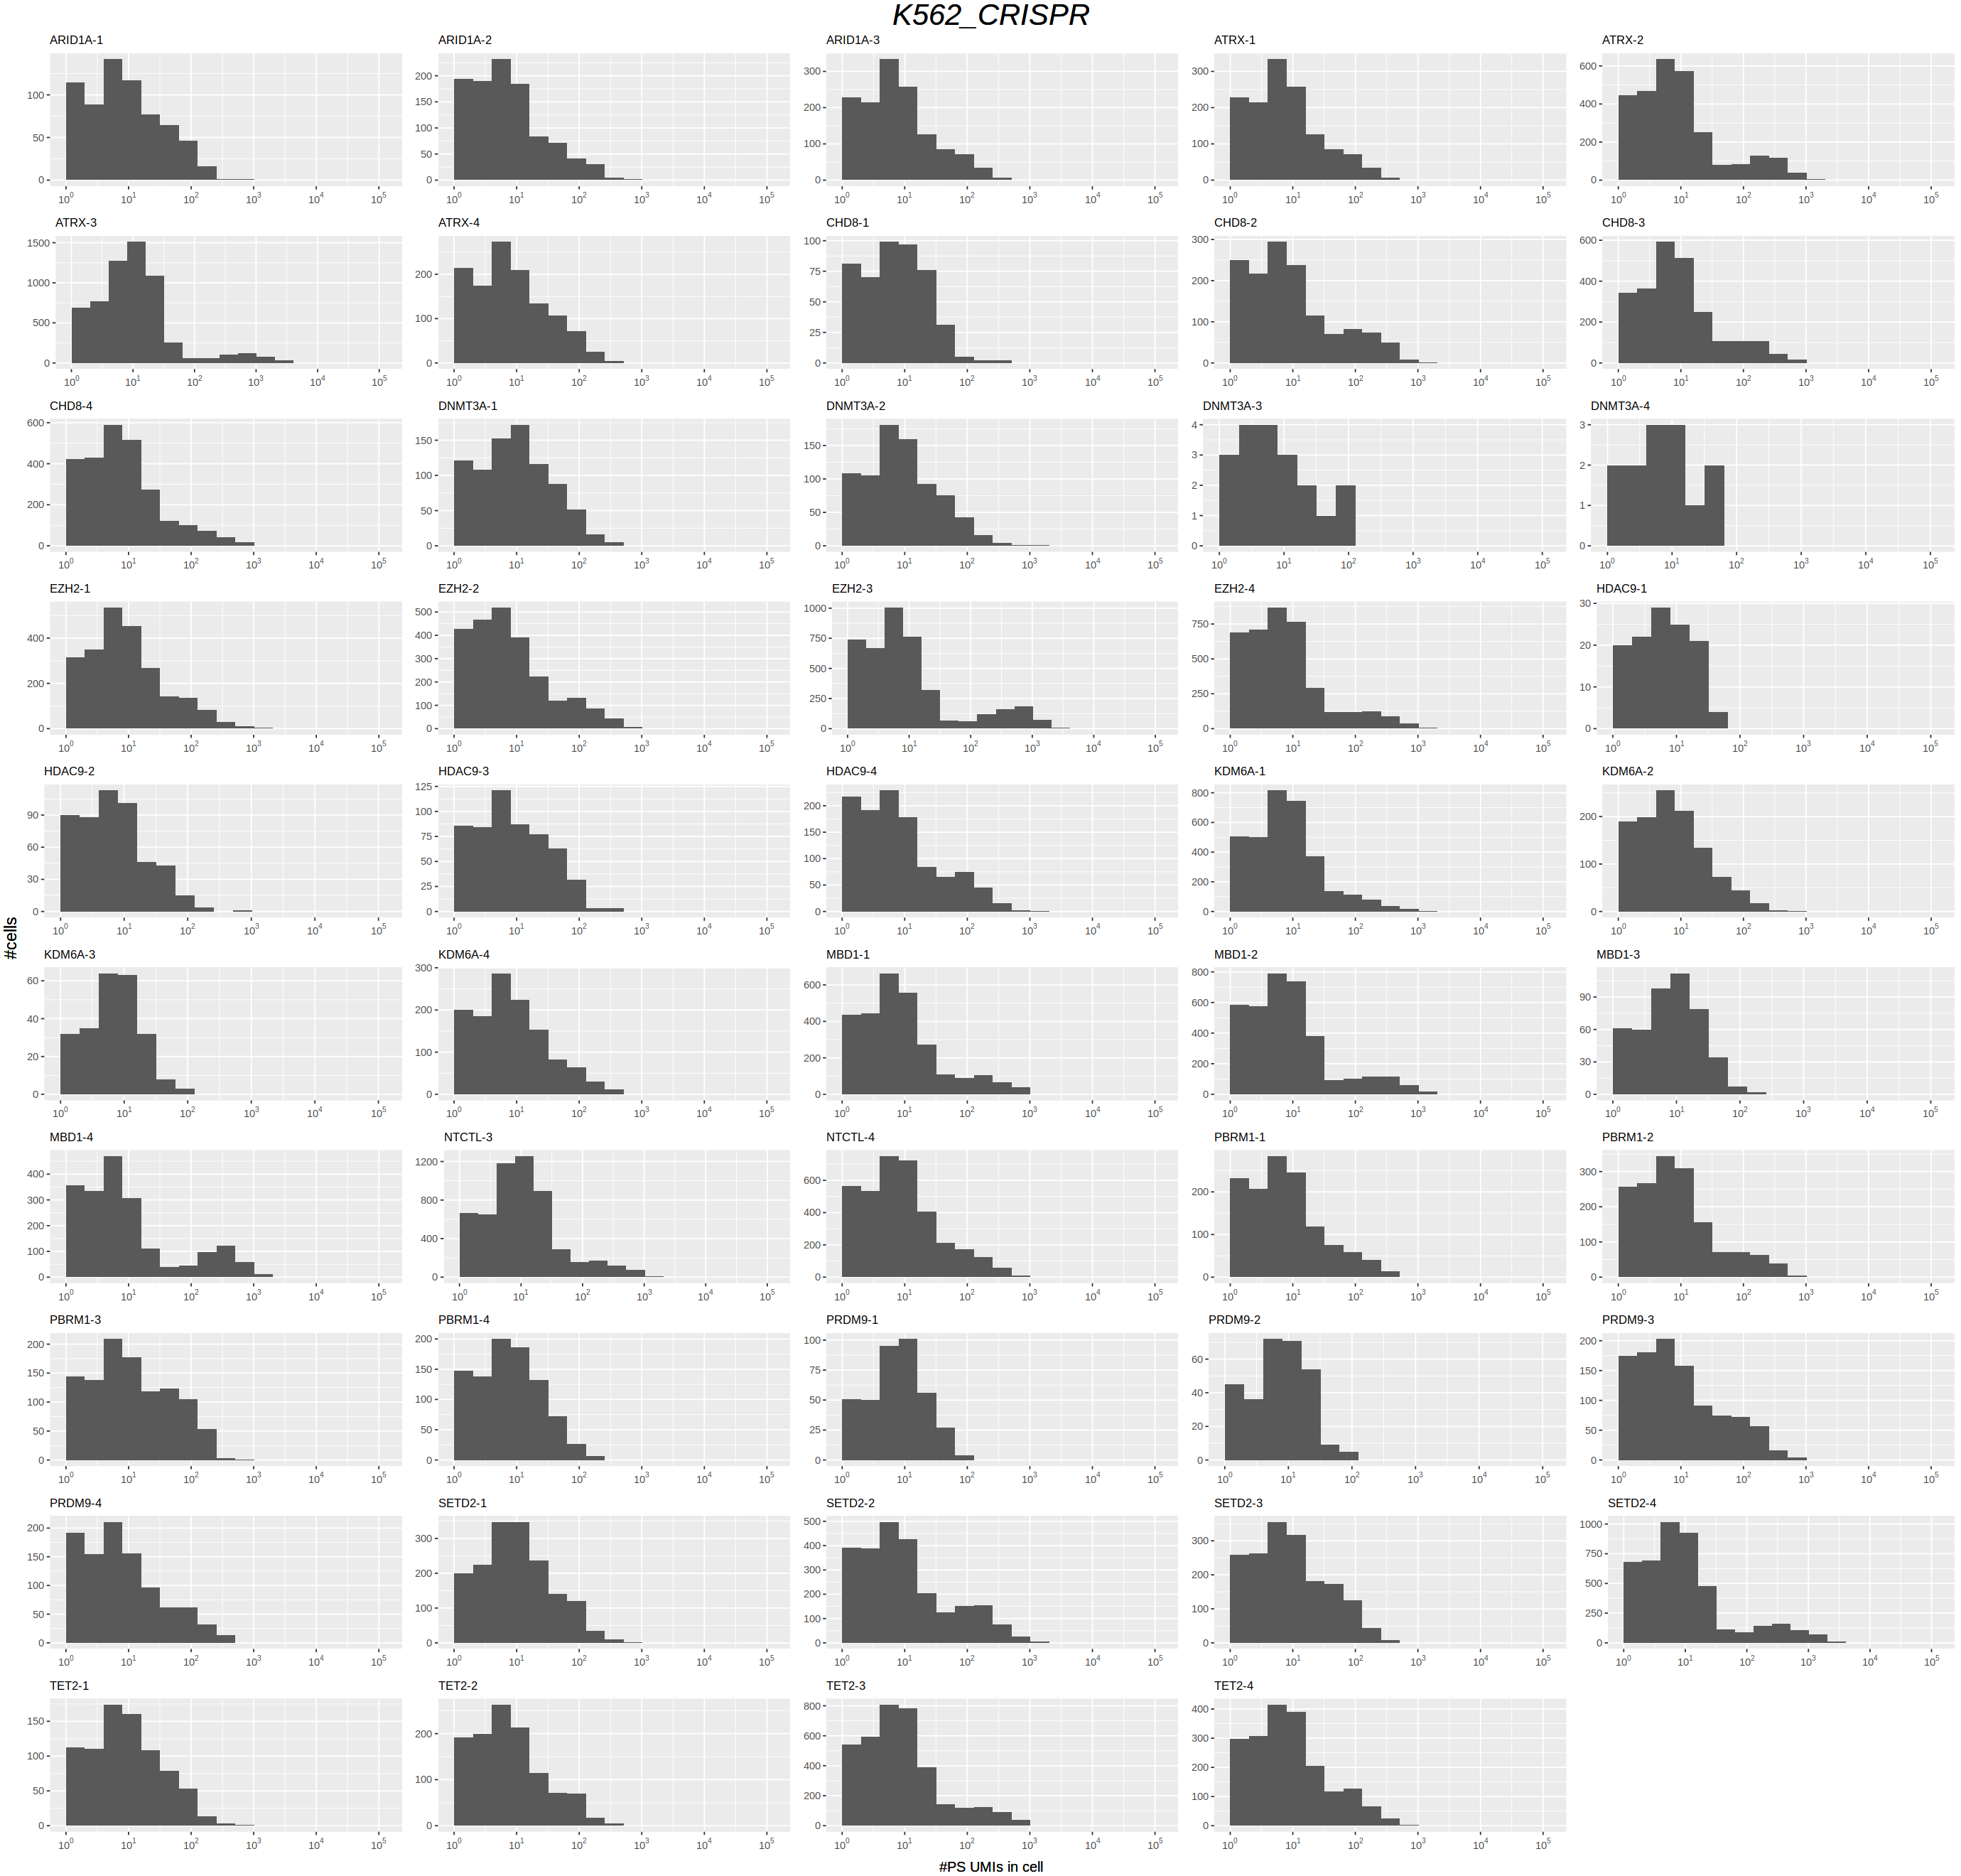

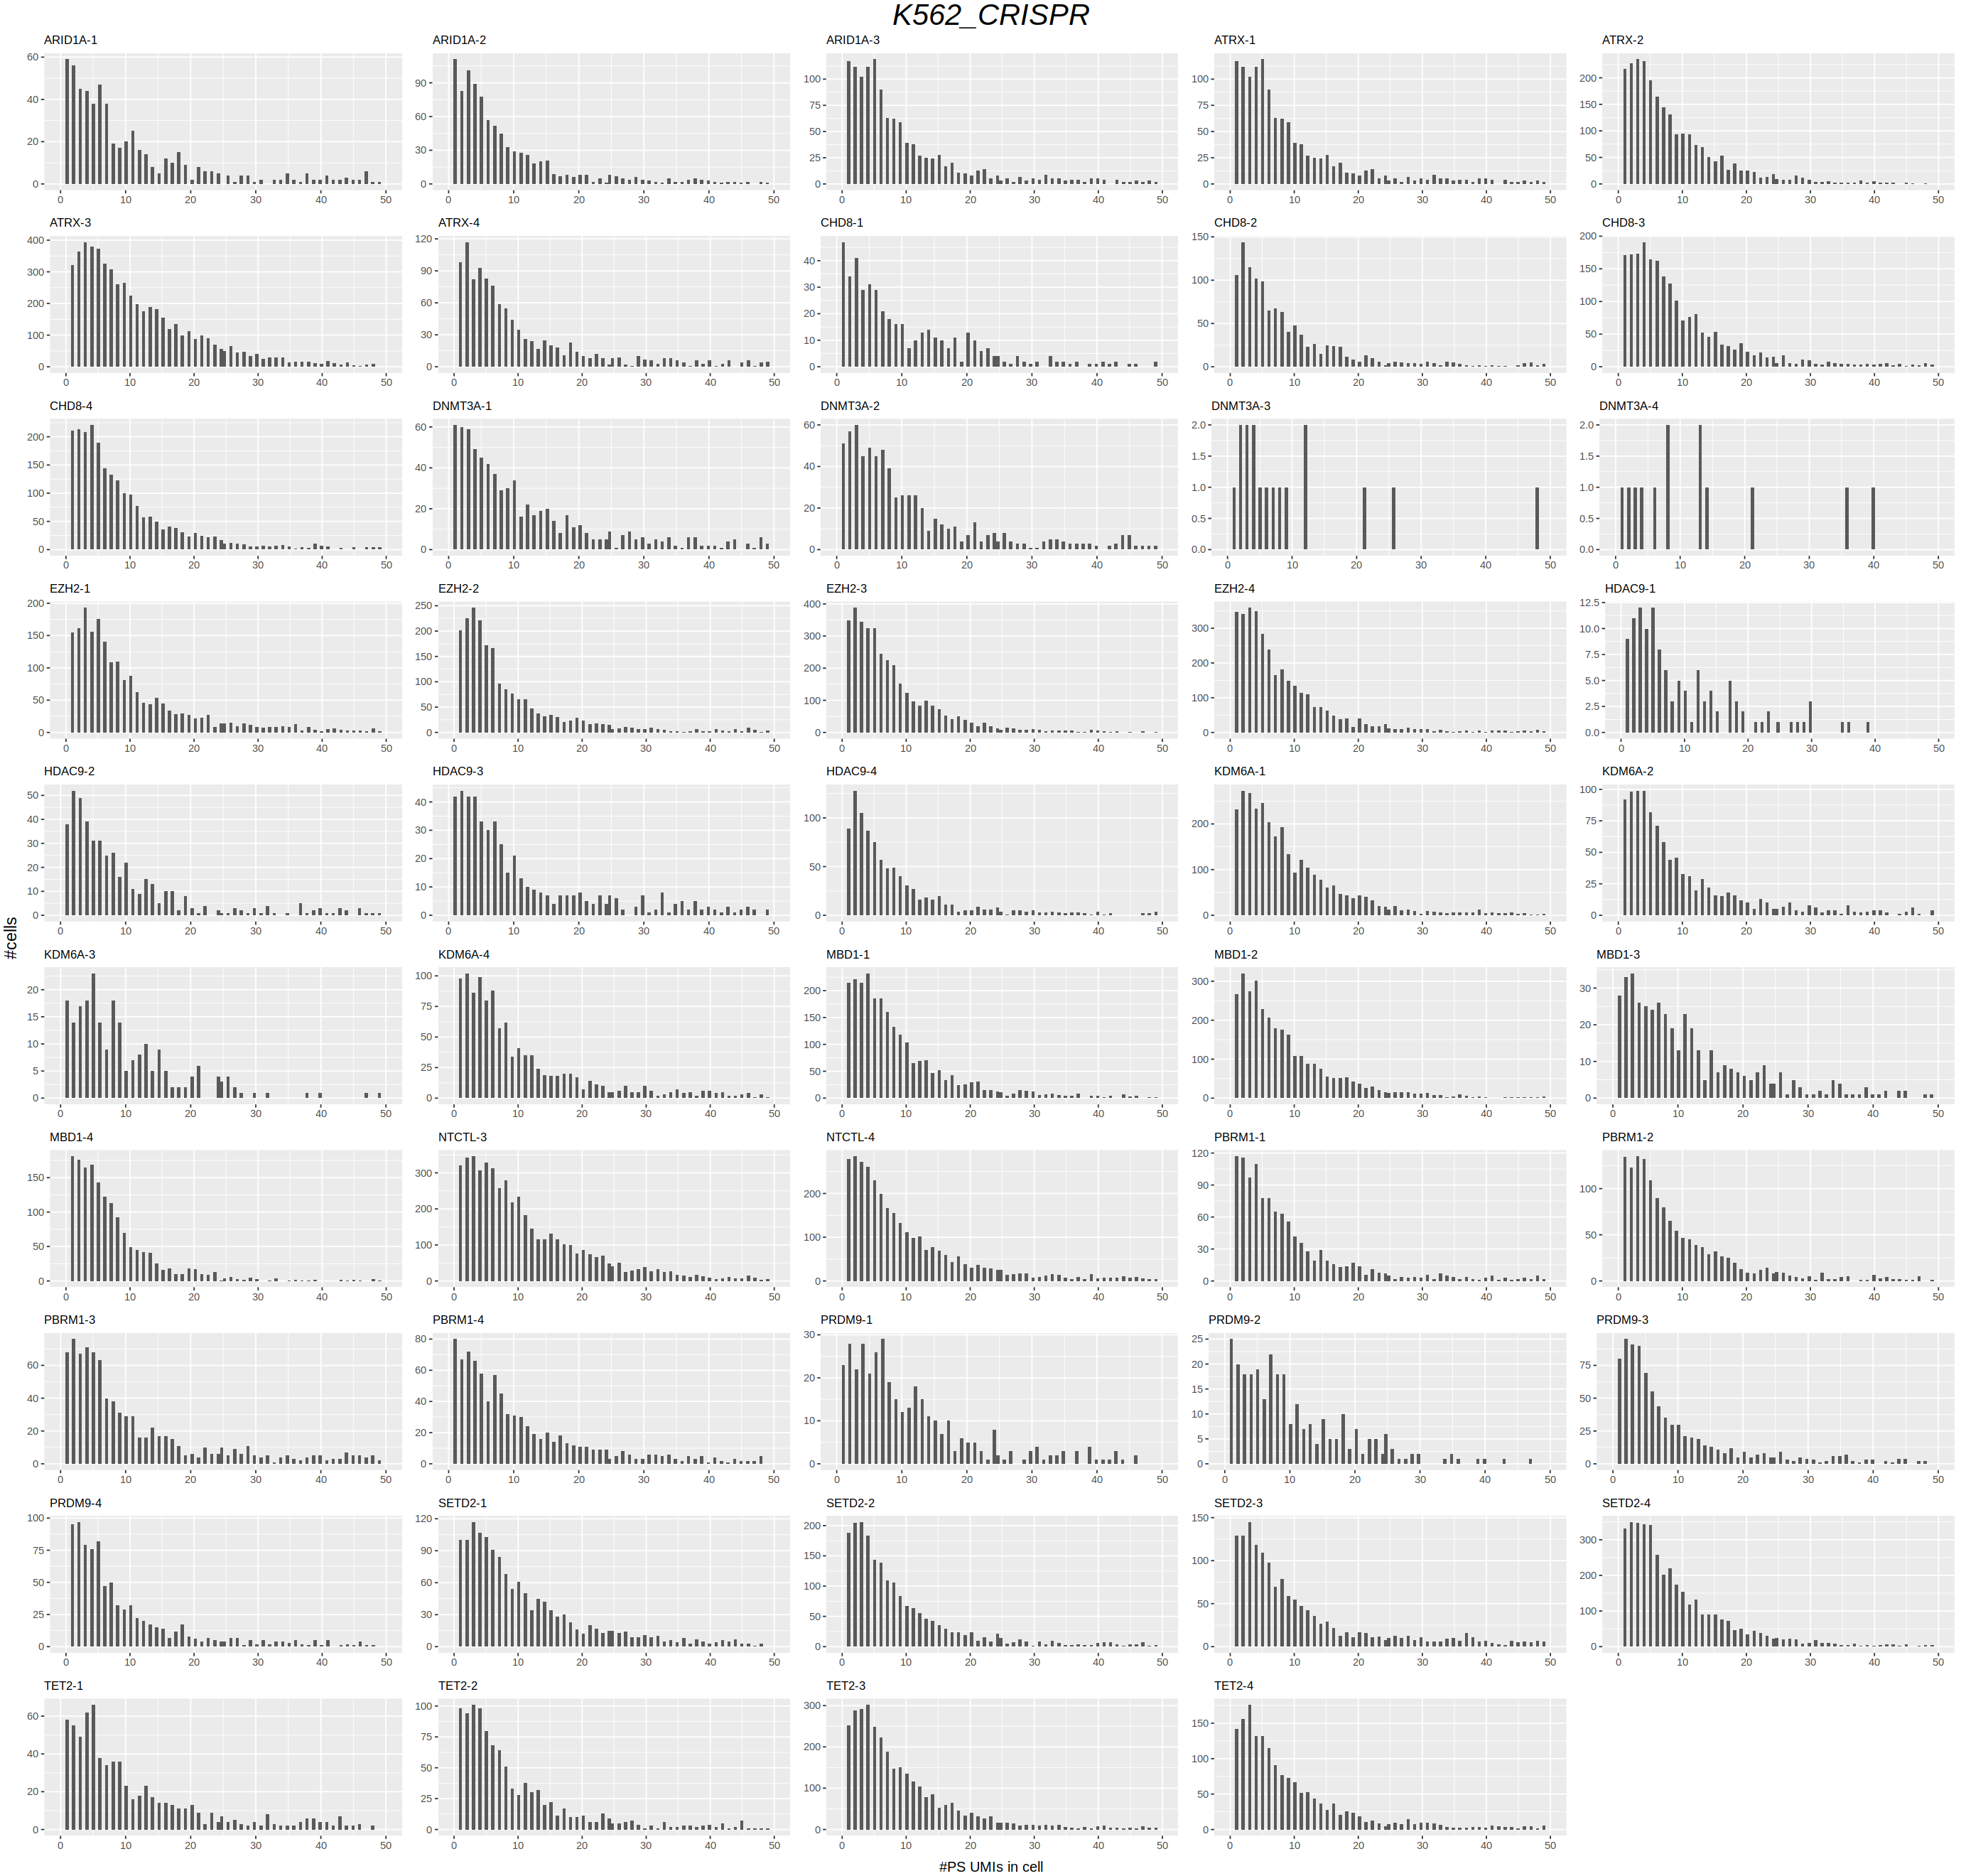

In [95]:
df_thresholds = data.frame(batch=character(0), guide=character(0), threshold=numeric(0))

cat(blue("Skipping guides with less than", min_guide_count, "counts in assay\n"))

# subset 
DefaultAssay(seurat) <- "sgRNA"
df_guide_counts <- as.data.frame(t(seurat[['sgRNA']]@counts))
rownames(df_guide_counts) <- NULL

CUTOFF_PROB = 0.5
guides = colnames(df_guide_counts)
plots = list()
log_plots = list()

for(i in seq_along(guides)) {
    guide = guides[[i]]
    y = df_guide_counts[ ,guide]
    select_nonzeros = y > 0
    y = y[select_nonzeros]
    cat(guide, length(y), "guides found\n")
    flush.console()
    if(length(y) <= min_guide_count) {
        cat("Skipping", guide, length(y), "guides found\n")
        next
    }
    
    filter_y = y > 0
    y_filtered = y[filter_y]
    df_y = as.data.frame(y_filtered)
    
    options(repr.plot.width=6, repr.plot.height=3)
    bin_breaks <- c(1,2,2*2^(1:16))
    title = paste0(guide)
    #print(hist(log(df_y$y_filtered), bins = 100))
    ggp1 <- ggplot(df_y, aes(x = y_filtered)) +    # Draw each column as histogram
        geom_histogram(bins=100) + 
        labs(title=title, x=NULL, y=NULL) +  
        theme(plot.title = element_text(size=10)) +
        xlim(0,50)
        #annotation_logticks(sides='b')
    #scale_x_log10() +

    #scale_x_log10(labels=trans_format('log10',math_format(10^.x)), breaks=c(1,10,100,1000,10000,100000)) +
    log_plots <- append(log_plots, list(ggp1))

    ggp1 <- ggplot(df_y, aes(x = y_filtered)) +    # Draw each column as histogram
        geom_histogram(breaks=bin_breaks) + 
        scale_x_log10(labels=trans_format('log10',math_format(10^.x)), breaks=c(1,10,100,1000,10000,100000)) +
        labs(title=title, x=NULL, y=NULL) +  
        theme(plot.title = element_text(size=10))

    plots <- append(plots, list(ggp1))
}
cat(green("Completed\n"))
flush.console()

options(repr.plot.width=23, repr.plot.height=22)
plt <- gridExtra::grid.arrange(
    grobs = plots,
    ncol = 5,
    bottom=textGrob("#PS UMIs in cell", gp=gpar(fontsize=12)),
    left=textGrob("#cells", gp=gpar(fontsize=14), rot=90),
    top = textGrob(library, gp=gpar(fontsize=25, font=3))
)
grid::grid.draw(plt)

options(repr.plot.width=23, repr.plot.height=22)
plt <- gridExtra::grid.arrange(
    grobs = log_plots,
    ncol = 5,
    bottom=textGrob("#PS UMIs in cell", gp=gpar(fontsize=12)),
    left=textGrob("#cells", gp=gpar(fontsize=14), rot=90),
    top = textGrob(library, gp=gpar(fontsize=25, font=3))
)


# Model the background distribution

Skipping guides with less than 10 counts in assay
ARID1A-1 669 guides found
NULL
ARID1A-2 1035 guides found
NULL
ARID1A-3 1359 guides found


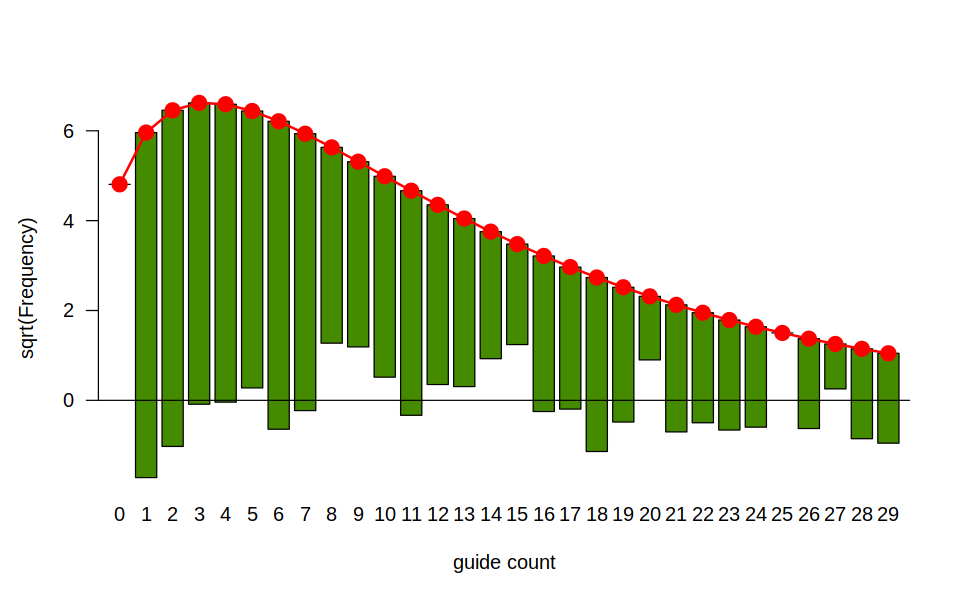

NULL
ARID1A-4 6 guides found
Skipping ARID1A-4 6 guides found
ATRX-1 1359 guides found


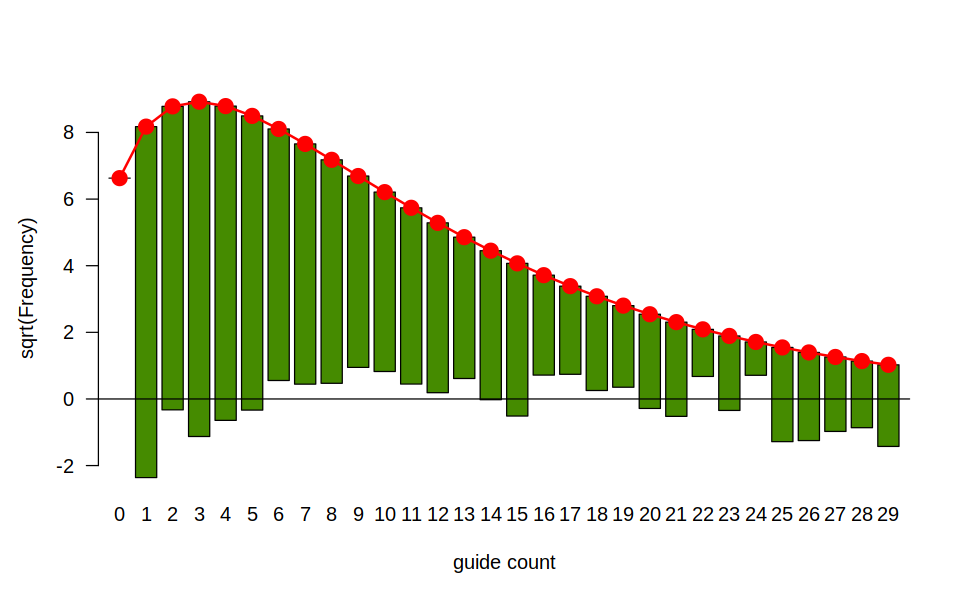

NULL
ATRX-2 2827 guides found


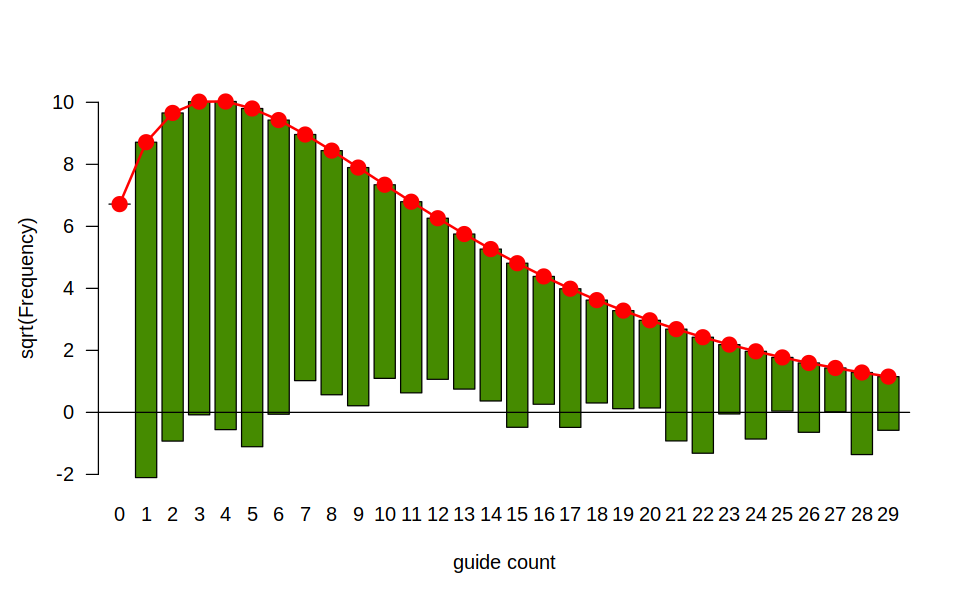

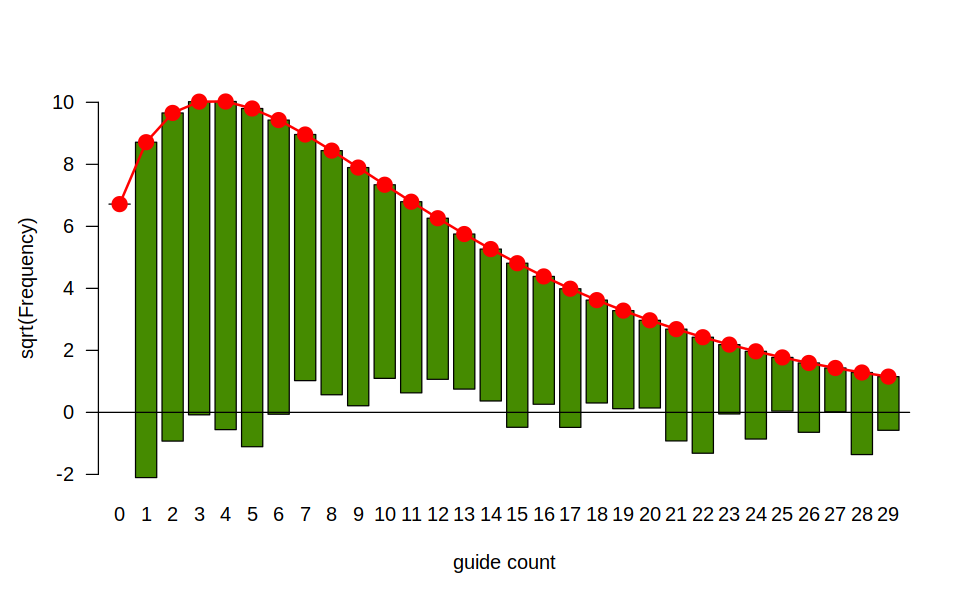

NULL
Completed


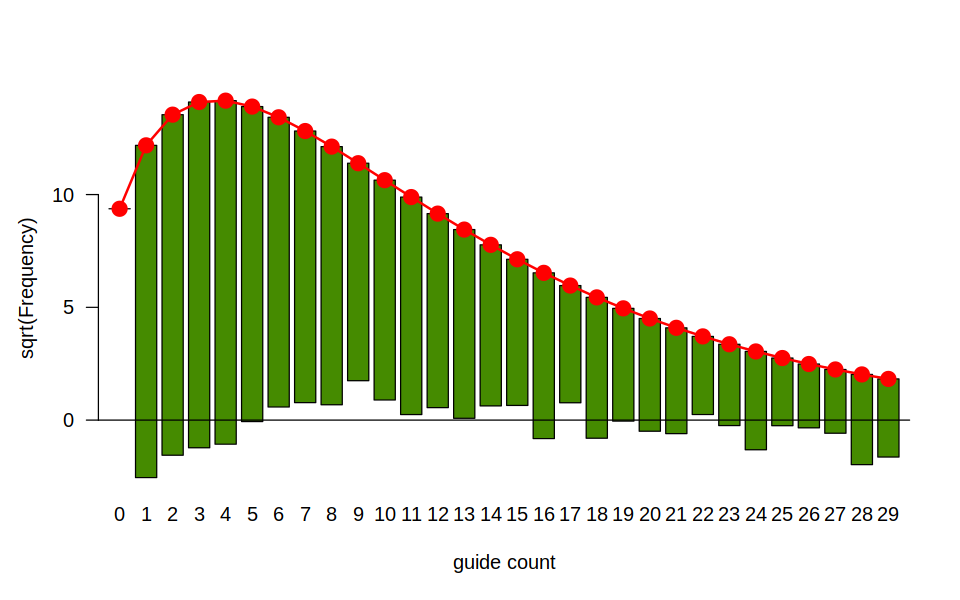

In [141]:
BACKG_CUTOFF = 30
df_thresholds = data.frame(batch=character(0), guide=character(0), threshold=numeric(0))

cat(blue("Skipping guides with less than", min_guide_count, "counts in assay\n"))

# subset 
DefaultAssay(seurat) <- "sgRNA"
df_guide_counts <- as.data.frame(t(seurat[['sgRNA']]@counts))
rownames(df_guide_counts) <- NULL

CUTOFF_PROB = 0.5
guides = colnames(df_guide_counts)
plots = list()
log_plots = list()

for(i in seq_along(guides)) {
    guide = guides[[i]]
    y = df_guide_counts[ ,guide]
    select_nonzeros = y > 0
    y = y[select_nonzeros]
    cat(guide, length(y), "guides found\n")
    flush.console()
    if(length(y) <= min_guide_count) {
        cat("Skipping", guide, length(y), "guides found\n")
        next
    }
        
    filter_y = y < BACKG_CUTOFF
    y_filtered = y[filter_y]
    df_y = as.data.frame(y_filtered)
    
    options(repr.plot.width=8, repr.plot.height=5)
    gf1 = goodfit( df_y$y, "nbinomial")
    print(rootogram(gf1, xlab = "guide count", rect_gp = gpar(fill = "chartreuse4")))
    if(i > 5) {
        break
    }
}
cat(green("Completed\n"))
flush.console()

### Linear histogram

Skipping guides with less than 10 counts in assay
ARID1A-1 669 guides found
ARID1A-2 1035 guides found
ARID1A-3 1359 guides found
ARID1A-4 6 guides found
Skipping ARID1A-4 6 guides found
ATRX-1 1359 guides found
ATRX-2 2827 guides found
ATRX-3 6040 guides found
ATRX-4 1213 guides found
CHD8-1 463 guides found
CHD8-2 1402 guides found
CHD8-3 2447 guides found
CHD8-4 2591 guides found
DNMT3A-1 831 guides found
DNMT3A-2 785 guides found
DNMT3A-3 19 guides found
DNMT3A-4 13 guides found
EZH2-1 2327 guides found
EZH2-2 2418 guides found
EZH2-3 4173 guides found
EZH2-4 3823 guides found
HDAC9-1 121 guides found
HDAC9-2 501 guides found
HDAC9-3 556 guides found
HDAC9-4 1106 guides found
KDM6A-1 3329 guides found
KDM6A-2 1128 guides found
KDM6A-3 237 guides found
KDM6A-4 1238 guides found
MBD1-1 2784 guides found
MBD1-2 3578 guides found
MBD1-3 453 guides found
MBD1-4 1953 guides found
NTCTL-3 5473 guides found
NTCTL-4 3551 guides found
PBRM1-1 1275 guides found
PBRM1-2 1584 guides found
PBRM1

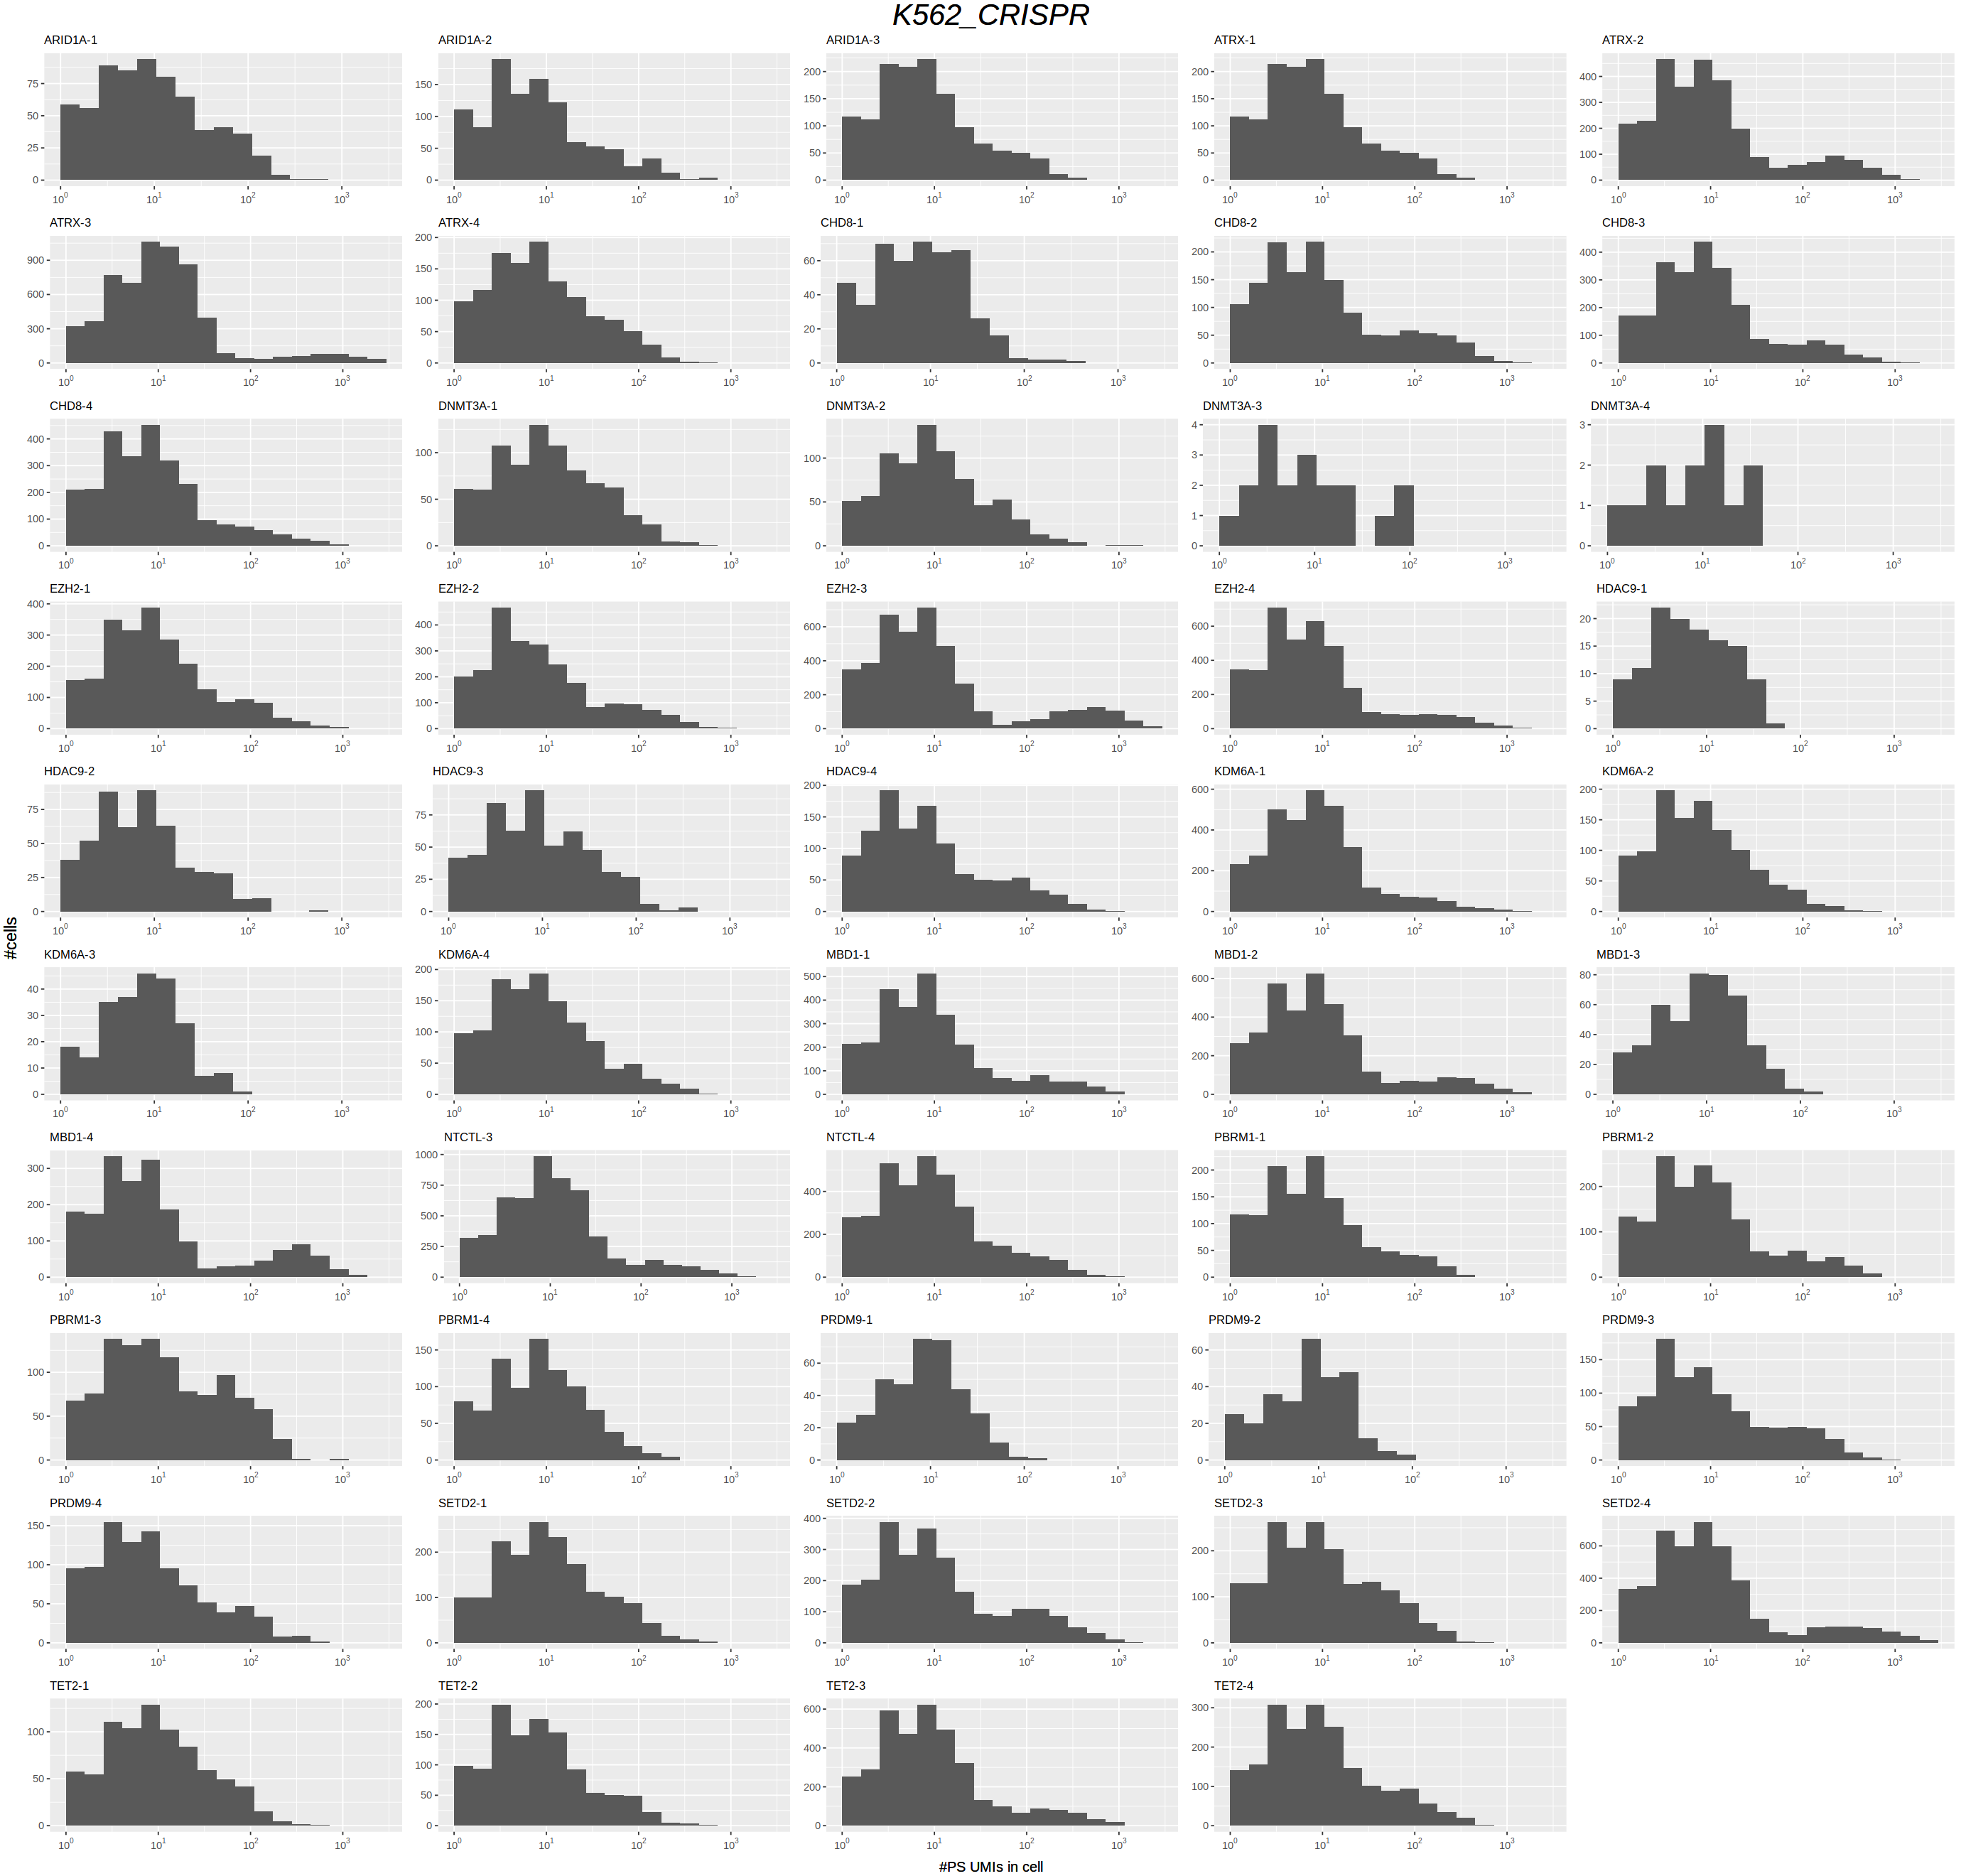

In [140]:
df_thresholds = data.frame(batch=character(0), guide=character(0), threshold=numeric(0))

cat(blue("Skipping guides with less than", min_guide_count, "counts in assay\n"))

# subset 
DefaultAssay(seurat) <- "sgRNA"
df_guide_counts <- as.data.frame(t(seurat[['sgRNA']]@counts))
rownames(df_guide_counts) <- NULL

CUTOFF_PROB = 0.5
guides = colnames(df_guide_counts)
plots = list()
log_plots = list()

for(i in seq_along(guides)) {
    guide = guides[[i]]
    y = df_guide_counts[ ,guide]
    select_nonzeros = y > 0
    y = y[select_nonzeros]
    cat(guide, length(y), "guides found\n")
    flush.console()
    if(length(y) <= min_guide_count) {
        cat("Skipping", guide, length(y), "guides found\n")
        next
    }
    
    df_y = as.data.frame(y)
    
    options(repr.plot.width=6, repr.plot.height=3)    
    title = paste0(guide)
    #print(hist(log(df_y$y_filtered), bins = 100))
    a = 1.6
    bin_breaks <- c(1, a, a*a^(1:16))    

    ggp1 <- ggplot(df_y, aes(x = y)) +    # Draw each column as histogram
        geom_histogram(breaks=bin_breaks) + 
        scale_x_log10(labels=trans_format('log10',math_format(10^.x)), breaks=c(1,10,100,1000,10000,100000)) +
        labs(title=title, x=NULL, y=NULL) +  
        theme(plot.title = element_text(size=10))

     plots <- append(plots, list(ggp1))
}

options(repr.plot.width=23, repr.plot.height=22)
plt <- gridExtra::grid.arrange(
    grobs = plots,
    ncol = 5,
    bottom=textGrob("#PS UMIs in cell", gp=gpar(fontsize=12)),
    left=textGrob("#cells", gp=gpar(fontsize=14), rot=90),
    top = textGrob(library, gp=gpar(fontsize=25, font=3))
)
grid::grid.draw(plt)


# Test Gaussian mixture

In [ ]:
# libraries = unique(seurat_combined$library)
# min_guide_count = 50
# df_thresholds = data.frame(batch=character(0), guide=character(0), threshold=numeric(0))

# cat(blue("Skipping guides with less than", min_guide_count, "counts\n"))
# for(l in seq_along(libraries)){
#     # subset 
#     library_name = libraries[[l]]
#     cat(blue("Running", library_name, "\n"))
#     seurat  <- subset(seurat_combined, subset = library == library_name)

#     DefaultAssay(seurat) <- "sgRNA"
#     df_guide_counts <- as.data.frame(t(seurat[['sgRNA']]@counts))
#     rownames(df_guide_counts) <- NULL

#     CUTOFF_PROB = 0.5
#     guides = colnames(df_guide_counts)
#     plots = list()

#     for(i in seq_along(guides)) {
#         guide = guides[[i]]
#         y = df_guide_counts[,guide]
#         select_nonzeros = y > 0
#         y = y[select_nonzeros]
#         if(length(y) <= min_guide_count) {
#             cat("Skipping", guide, length(y), "guides found\n")
#             next
#         }
        
#         calls <- pgmix(y)
#         df_calls = as.data.frame(calls)
#         df_calls['counts'] = y
#         colnames(df_calls) = c('call', 'prob', 'count')
#         options(repr.plot.width=4, repr.plot.height=4)
#         head(df_calls)
#         dim(df_calls)
#         select_gaussian_assigned = df_calls[, 'prob'] > CUTOFF_PROB

#         df_gauss = df_calls[select_gaussian_assigned,]
#         dim(df_gauss)
        
#         # head(df_gauss)
#         threshold = min(df_gauss$count)
#         #cat("threshold=", threshold)
#         filter_y = y > 0
#         y_filtered = y[filter_y]
#         df_y = as.data.frame(y_filtered)
#         head(df_y)
        
#         options(repr.plot.width=3.3, repr.plot.height=2.4)
#         bin_breaks <- c(1,2,2*2^(1:16))
#         title = paste0(guide, ", T=", threshold)

#         ggp1 <- ggplot(df_y, aes(x = y_filtered)) +    # Draw each column as histogram
#         geom_histogram(breaks=bin_breaks) + 
#         scale_x_log10(labels=trans_format('log10',math_format(10^.x)), breaks=c(1,10,100,1000,10000,100000)) +
#             labs(title=title, x=NULL, y=NULL) +  
#             geom_vline(xintercept=threshold, color="blue", linetype="dashed", size=1) +
#             theme(plot.title = element_text(size=10))

#         plots <- append(plots, list(ggp1))
#         index = nrow(df_thresholds) + 1
#         df_thresholds[index,] <-  c(library_name, guide, threshold)
#     }
#     cat(green("Completed", library_name, "\n"))
#     flush.console()
#     options(repr.plot.width=35, repr.plot.height=20)
#     plt <- gridExtra::grid.arrange(
#         grobs = plots, 
#         ncol = 14, 
#         bottom=textGrob("#PS UMIs in cell", gp=gpar(fontsize=12)),
#         left=textGrob("#cells", gp=gpar(fontsize=14), rot=90),
#         top = textGrob(library_name, gp=gpar(fontsize=25, font=3))
#     )
#     grid::grid.draw(plt)
    
# }